In [1]:
#gy3312
#jaydebsarker
#hw5:DT

import csv 
import collections

In [ ]:
def loadCSV(file):
    """Loads a CSV file and converts all floats and ints into basic datatypes.""" 
    def convertTypes(s):
        s = s.strip()
        try:
            return float(s) if '.' in s else int(s)
        except ValueError:
            return s

    reader = csv.reader(open(file, 'rt'))
    return [[convertTypes(item) for item in row] for row in reader]

In [ ]:
#spliting the dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

trainingData = loadCSV('adult.csv')

print(trainingData[0])

df = pd.DataFrame(trainingData)
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df['income_num'] = pd.factorize(df['income'])[0]

df = df.drop(['income'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['income_num'], axis=1), df['income_num'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
#creating DT classes
#I created the DT from here

In [2]:
class DecisionTree:
    """Decision tree implementation using c4.5 algorithm"""
    def __init__(self, col=-1, value=None, trueBranch=None, falseBranch=None, results=None):
        self.col = col
        self.value = value
        self.trueBranch = trueBranch
        self.falseBranch = falseBranch
        self.results = results # None for nodes, not None for leaves

In [3]:
def divideSet(rows, column, value):
    splittingFunction = None
    if isinstance(value, int) or isinstance(value, float): # for int and float values
        splittingFunction = lambda row : row[column] >= value
    else: # for strings 
        splittingFunction = lambda row : row[column] == value
    list1 = [row for row in rows if splittingFunction(row)]
    list2 = [row for row in rows if not splittingFunction(row)]
    return (list1, list2)

In [4]:
def uniqueCounts(rows):
    results = {}
    for row in rows:
        r = row[-1]
        if r not in results: results[r] = 0
        results[r] += 1
    return results

In [5]:
def entropy(rows):
    from math import log
    log2 = lambda x: log(x)/log(2)
    results = uniqueCounts(rows)

    entr = 0.0
    for r in results:
        p = float(results[r])/len(rows)
        entr -= p*log2(p)
    return entr

In [6]:
def gini(rows):
    total = len(rows)
    counts = uniqueCounts(rows)
    imp = 0.0

    for k1 in counts:
        p1 = float(counts[k1])/total  
        for k2 in counts:
            if k1 == k2: continue
            p2 = float(counts[k2])/total
            imp += p1*p2
    return imp

In [7]:
def variance(rows):
    if len(rows) == 0: return 0
    data = [float(row[len(row) - 1]) for row in rows]
    mean = sum(data) / len(data)

    variance = sum([(d-mean)**2 for d in data]) / len(data)
    return variance

In [8]:
def growDecisionTreeFrom(rows, evaluationFunction=entropy):
  

    if len(rows) == 0: return DecisionTree()
    currentScore = evaluationFunction(rows)

    bestGain = 0.0
    bestAttribute = None
    bestSets = None

    columnCount = len(rows[0]) - 1  # last column is the result/target column
    for col in range(0, columnCount):
        columnValues = [row[col] for row in rows]

        for value in columnValues:
            (set1, set2) = divideSet(rows, col, value)

            # Gain -- Entropy or Gini
            p = float(len(set1)) / len(rows)
            gain = currentScore - p*evaluationFunction(set1) - (1-p)*evaluationFunction(set2)
            if gain>bestGain and len(set1)>0 and len(set2)>0:
                bestGain = gain
                bestAttribute = (col, value)
                bestSets = (set1, set2)

    if bestGain > 0:
        trueBranch = growDecisionTreeFrom(bestSets[0])
        falseBranch = growDecisionTreeFrom(bestSets[1])
        return DecisionTree(col=bestAttribute[0], value=bestAttribute[1], trueBranch=trueBranch, falseBranch=falseBranch)
    else:
        return DecisionTree(results=uniqueCounts(rows))

In [15]:
def prune(tree, minGain, evaluationFunction=entropy, notify=False):
    
    # recursive call for each branch
    if tree.trueBranch.results == None: prune(tree.trueBranch, minGain, evaluationFunction, notify)
    if tree.falseBranch.results == None: prune(tree.falseBranch, minGain, evaluationFunction, notify)

    # merge leaves (potentionally)
    if tree.trueBranch.results != None and tree.falseBranch.results != None:
        tb, fb = [], []

        for v, c in tree.trueBranch.results.items(): tb += [[v]] * c
        for v, c in tree.falseBranch.results.items(): fb += [[v]] * c

        p = float(len(tb)) / len(tb + fb)
        delta = evaluationFunction(tb+fb) - p*evaluationFunction(tb) - (1-p)*evaluationFunction(fb)
        if delta < minGain:	
            if notify:  
            tree.trueBranch, tree.falseBranch = None, None
            tree.results = uniqueCounts(tb + fb)

IndentationError: expected an indented block (<ipython-input-15-3b52805771da>, line 18)

In [10]:
def classify(observations, tree, dataMissing=False):
 

    def classifyWithoutMissingData(observations, tree):
        if tree.results != None:  # leaf
            return tree.results
        else:
            v = observations[tree.col]
            branch = None
            if isinstance(v, int) or isinstance(v, float):
                if v >= tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch
            else:
                if v == tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch
        return classifyWithoutMissingData(observations, branch)


    def classifyWithMissingData(observations, tree):
        if tree.results != None:  # leaf 
            return tree.results
        else:
            v = observations[tree.col]
            if v == None:
                tr = classifyWithMissingData(observations, tree.trueBranch)
                fr = classifyWithMissingData(observations, tree.falseBranch)
                tcount = sum(tr.values())
                fcount = sum(fr.values())
                tw = float(tcount)/(tcount + fcount)
                fw = float(fcount)/(tcount + fcount)
                result = collections.defaultdict(int)
                for k, v in tr.items(): result[k] += v*tw
                for k, v in fr.items(): result[k] += v*fw
                return dict(result)
            else:
                branch = None
                if isinstance(v, int) or isinstance(v, float):
                    if v >= tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch
                else:
                    if v == tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch
            return classifyWithMissingData(observations, branch)

    # function body
    if dataMissing: 
        return classifyWithMissingData(observations, tree)
    else: 
        return classifyWithoutMissingData(observations, tree)

In [11]:
def plot(decisionTree):
    """Plots the obtained decision tree. """
    def toString(decisionTree, indent=''):
        if decisionTree.results != None:  # leaf node
            return str(decisionTree.results)
        else:
            if isinstance(decisionTree.value, int) or isinstance(decisionTree.value, float):
                decision = 'Column %s: x >= %s?' % (decisionTree.col, decisionTree.value)
            else:
                decision = 'Column %s: x == %s?' % (decisionTree.col, decisionTree.value)
            trueBranch = indent + 'yes -> ' + toString(decisionTree.trueBranch, indent + '\t\t')
            falseBranch = indent + 'no  -> ' + toString(decisionTree.falseBranch, indent + '\t\t')
            return (decision + '\n' + trueBranch + '\n' + falseBranch)

    print(toString(decisionTree))

In [13]:
#run classifier

 
X_tr = X_train
X_tr['income_num'] = y_train #add the target value

p = X_tr.values.tolist()


['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


In [14]:
decisionTree = growDecisionTreeFrom(p)
#decisionTree = growDecisionTreeFrom(trainingData, evaluationFunction=gini) # with gini
#plot(decisionTree)

In [16]:
error = []
cutof = [0.2,0.4,0.6,0.8]
for i in cutof:
    prune(decisionTree, i, notify=True)
    #cou = 0
    err = 0
    for ind in range(X_val.shape[0]):
         
        m = False
        for j in range(X_val.shape[1]):
            v = str(X_val._get_value(ind, j, takeable = True))
            if v=='?':
                #print(X_val.iloc[ind])
                m = True
                break

        inst = X_val.iloc[ind].values.flatten().tolist()
        #print(inst)
        #print(classify(['37', 'private','188774', 'Bachelors', '13', 'Never-married','Exec-managerial','Not-in-family', 'White', 'Male', '0', '2824','40','United-States'], decisionTree, dataMissing=False))
        s = str(classify(inst, decisionTree, dataMissing=m))
        if s[1]!=str(y_val.iloc[ind]):
            err+=1
            #print(s[1]) 
        #cou +=1

    print("Error for cut-off: ",i," is:",err/X_val.shape[0])
    error.append(err/X_val.shape[0])

A branch was pruned: gain = 0.032600
A branch was pruned: gain = 0.116115
A branch was pruned: gain = 0.007914
A branch was pruned: gain = 0.070012
A branch was pruned: gain = 0.080136
Error for cut-off:  0.2  is: 0.20690978886756237
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.258019
A branch was pruned: gain = 0.297472
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.276195
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.205110
A branch was pruned: gain = 0.228538
A branch was pruned: gain = 0.322757
A branch was pruned: gain = 0.322757
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.020714
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.276195
A branch was pruned: gain 

Error for cut-off:  0.8  is: 0.28291746641074855


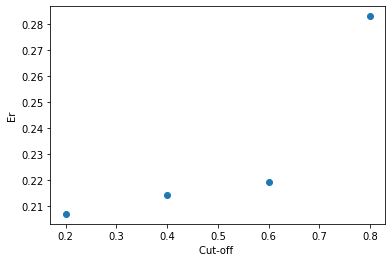

In [17]:
#plotting the error with cutoff for validation
from matplotlib import pyplot as plt

#print(error)
#print(cutof)
error1 = []
for i in range(4):
    error1.append(error[i])
plt.scatter(cutof,error1)
plt.xlabel("Cut-off ")
plt.ylabel("Er")
plt.show()

In [18]:
#testing data
err = 0
for ind in range(X_test.shape[0]):
    
    m = False
    for j in range(X_test.shape[1]):
        v = str(X_test._get_value(ind, j, takeable = True))
        if v=='?':
            #print(X_val.iloc[ind])
            m = True
            break

    inst = X_test.iloc[ind].values.flatten().tolist()
     
    s = str(classify(inst, decisionTree, dataMissing=m))
    if s[1]!=str(y_test.iloc[ind]):
        err+=1
    

print("Test error is:",err/X_test.shape[0])
error.append(err/X_test.shape[0])

Test error is: 0.27391371103945955


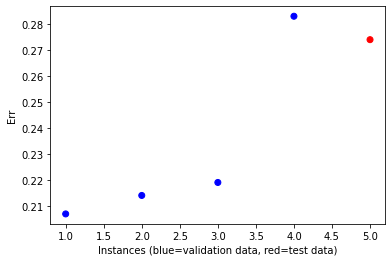

In [19]:
plt.scatter([1,2,3,4,5],error,color=['blue','blue','blue','blue','red'])
plt.xlabel("Instances (blue=validation data, red=test data)")
plt.ylabel("Err")
plt.show()